In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight
import joblib
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set plot style for better aesthetics
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)

# Data Loading and Initial Inspection

In [3]:
df = pd.read_csv('Time-Series_Network_logs.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values('Timestamp').reset_index(drop=True)

In [4]:
print("First 5 rows of the dataset:")
df.head()

First 5 rows of the dataset:


,Timestamp,Source_IP,Destination_IP,Port,Request_Type,Protocol,Payload_Size,User_Agent,Status,Intrusion,Scan_Type
0,2025-06-01 00:00:48,192.168.250.144,183.181.176.96,22,SMTP,UDP,2792,Nikto/2.1.6,Success,0,Normal
1,2025-06-01 00:00:48,192.168.69.89,73.177.254.139,80,FTP,UDP,2214,nmap/7.80,Success,0,Normal
2,2025-06-01 00:01:17,192.168.68.58,151.14.73.23,22,FTP,UDP,1611,Mozilla/5.0,Success,0,Normal
3,2025-06-01 00:03:38,192.168.61.18,80.21.75.32,21,HTTP,TCP,2200,curl/7.68.0,Success,0,Normal
4,2025-06-01 00:03:42,192.168.240.92,133.113.54.71,53,HTTP,TCP,2878,curl/7.68.0,Success,0,Normal


In [5]:
print("\nDataset Information:")
df.info()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8866 entries, 0 to 8865
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Timestamp       8866 non-null   datetime64[ns]
 1   Source_IP       8866 non-null   object        
 2   Destination_IP  8866 non-null   object        
 3   Port            8866 non-null   int64         
 4   Request_Type    8866 non-null   object        
 5   Protocol        8866 non-null   object        
 6   Payload_Size    8866 non-null   int64         
 7   User_Agent      8866 non-null   object        
 8   Status          8866 non-null   object        
 9   Intrusion       8866 non-null   int64         
 10  Scan_Type       8866 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(7)
memory usage: 762.0+ KB


In [6]:
print("\nChecking for missing values:")
df.isnull().sum()


Checking for missing values:


Timestamp         0
Source_IP         0
Destination_IP    0
Port              0
Request_Type      0
Protocol          0
Payload_Size      0
User_Agent        0
Status            0
Intrusion         0
Scan_Type         0
dtype: int64

* Target Variable and Class Imbalance Analysis

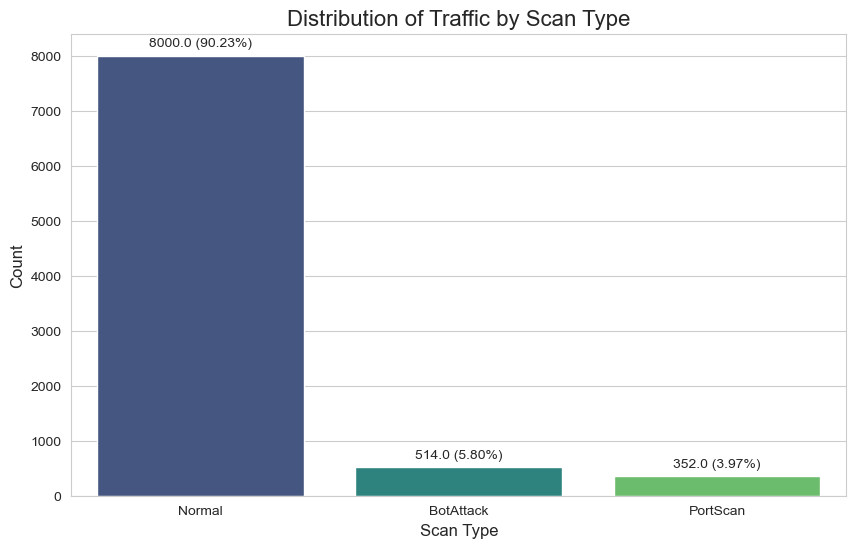

In [7]:
# Plotting the distribution of Scan Types
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Scan_Type', data=df, palette='viridis', order=df['Scan_Type'].value_counts().index)
plt.title('Distribution of Traffic by Scan Type', fontsize=16)
plt.xlabel('Scan Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
for p in ax.patches:
    ax.annotate(f'{p.get_height()} ({p.get_height()/len(df)*100:.2f}%)',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 9), textcoords='offset points')
plt.show()

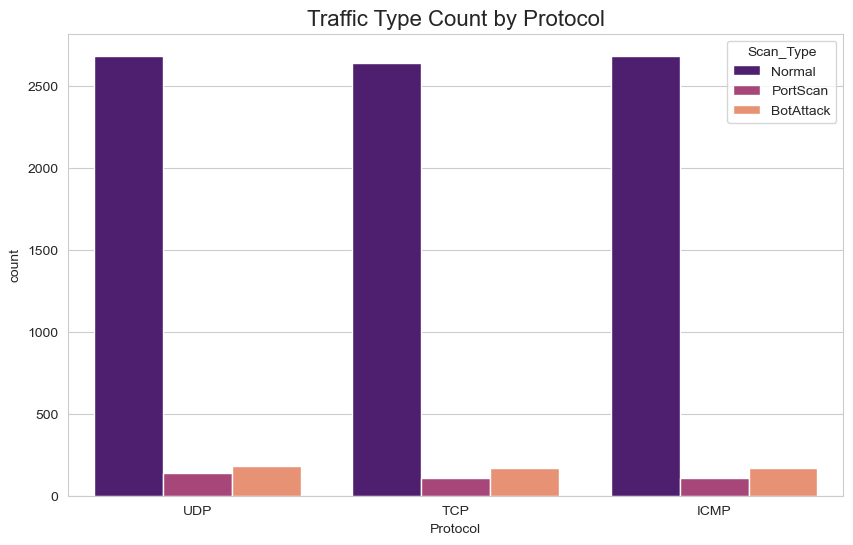

In [8]:
# Protocol vs. Scan Type
plt.figure(figsize=(10, 6))
sns.countplot(x='Protocol', hue='Scan_Type', data=df, palette='magma')
plt.title('Traffic Type Count by Protocol', fontsize=16)
plt.show()

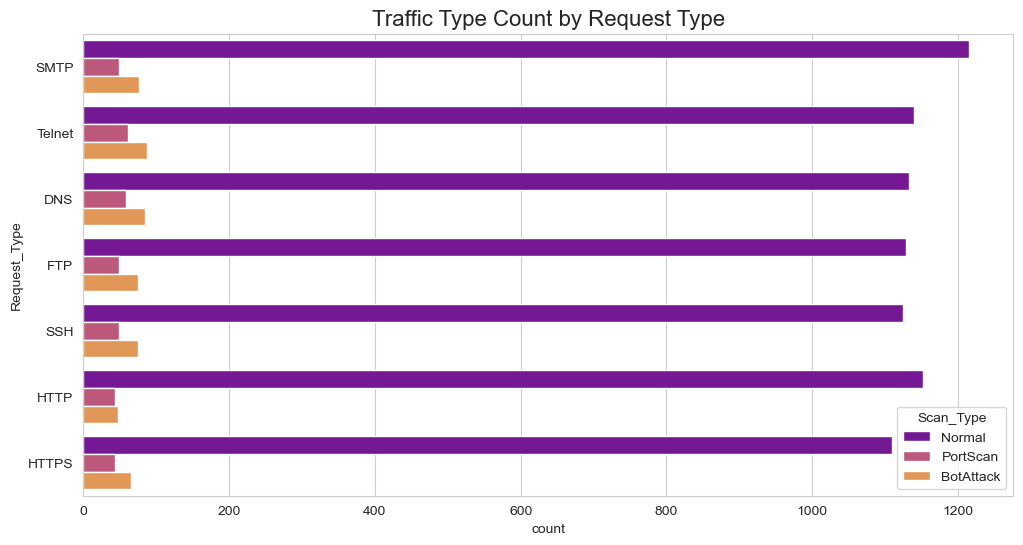

In [9]:
# Request Type vs. Scan Type
plt.figure(figsize=(12, 6))
sns.countplot(y='Request_Type', hue='Scan_Type', data=df, palette='plasma', order=df['Request_Type'].value_counts().index)
plt.title('Traffic Type Count by Request Type', fontsize=16)
plt.show()

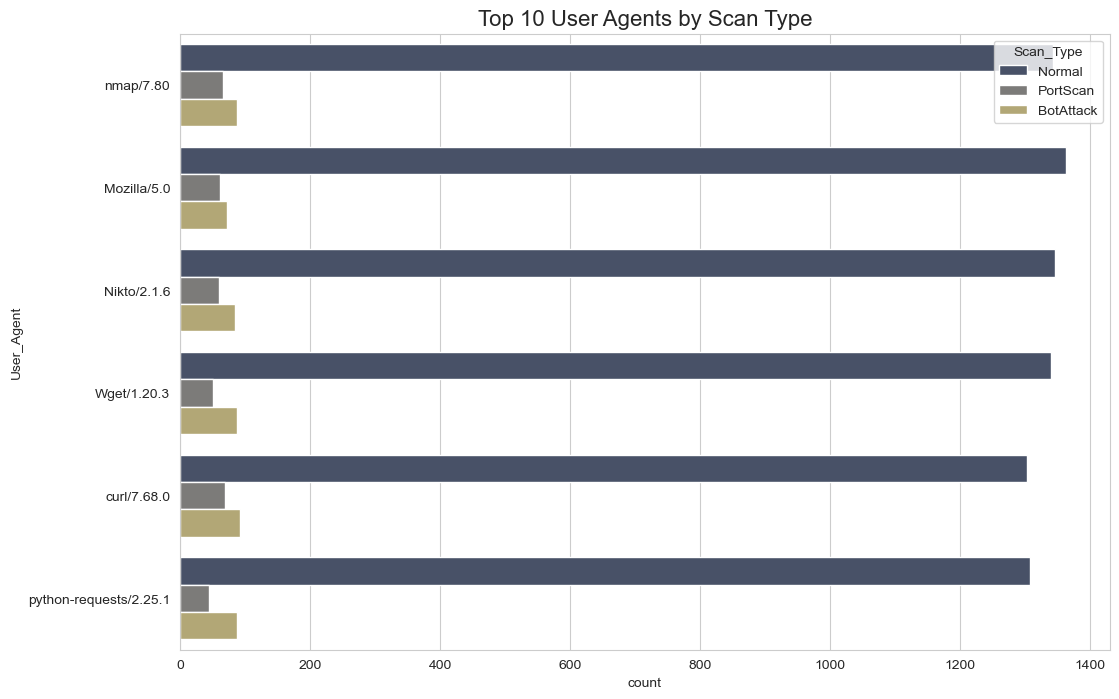

In [10]:
# User Agent vs. Scan Type (Top 10)
plt.figure(figsize=(12, 8))
top_user_agents = df['User_Agent'].value_counts().index[:10]
sns.countplot(y='User_Agent', hue='Scan_Type', data=df[df['User_Agent'].isin(top_user_agents)], palette='cividis', order=top_user_agents)
plt.title('Top 10 User Agents by Scan Type', fontsize=16)
plt.show()

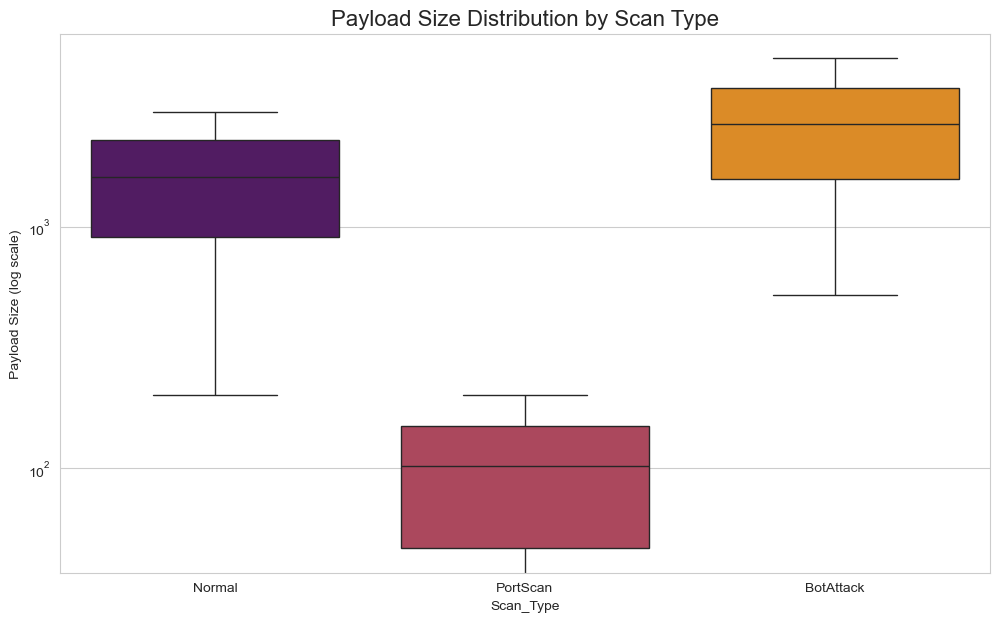

In [11]:
# Payload Size Distribution by Scan Type
plt.figure(figsize=(12, 7))
sns.boxplot(x='Scan_Type', y='Payload_Size', data=df, palette='inferno')
plt.title('Payload Size Distribution by Scan Type', fontsize=16)
plt.yscale('log') # Use log scale due to wide range of values
plt.ylabel('Payload Size (log scale)')
plt.show()

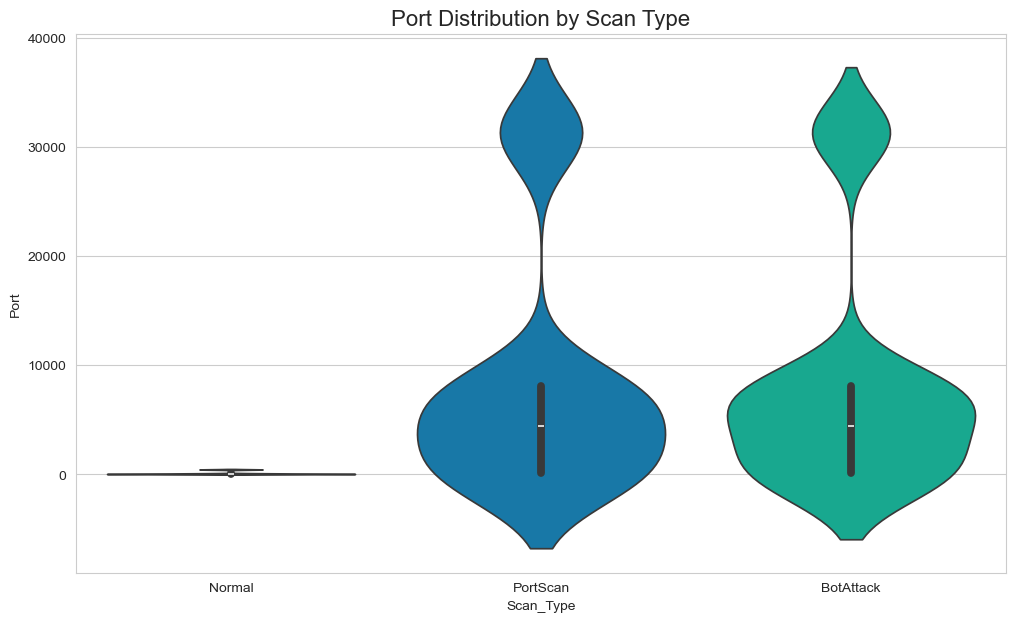

In [12]:
# Port Distribution by Scan Type
plt.figure(figsize=(12, 7))
sns.violinplot(x='Scan_Type', y='Port', data=df, palette='winter')
plt.title('Port Distribution by Scan Type', fontsize=16)
plt.show()

* IP Address Analysis

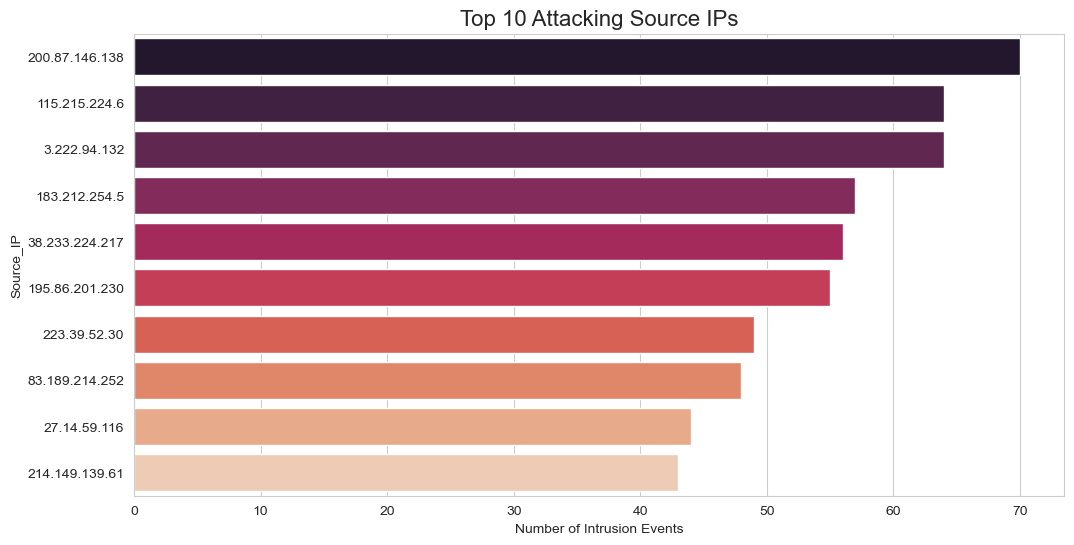

In [13]:
# Top 10 Attacking Source IPs
plt.figure(figsize=(12, 6))
top_attack_ips = df[df['Intrusion'] == 1]['Source_IP'].value_counts().head(10)
sns.barplot(y=top_attack_ips.index, x=top_attack_ips.values, palette='rocket', orient='h')
plt.title('Top 10 Attacking Source IPs', fontsize=16)
plt.xlabel('Number of Intrusion Events')
plt.show()

* Temporal Analysis

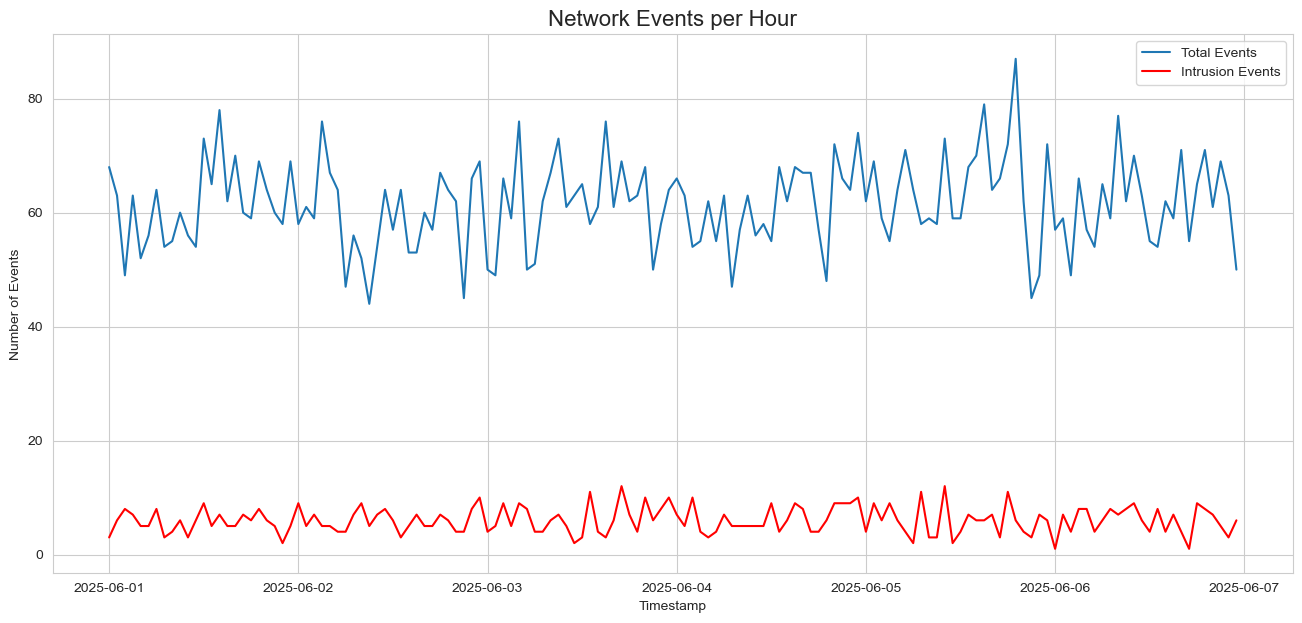

In [14]:
# Intrusion events over time
df_resampled = df.set_index('Timestamp').resample('H').size().reset_index(name='count')
df_intrusions_resampled = df[df['Intrusion'] == 1].set_index('Timestamp').resample('H').size().reset_index(name='intrusion_count')

plt.figure(figsize=(16, 7))
plt.plot(df_resampled['Timestamp'], df_resampled['count'], label='Total Events')
plt.plot(df_intrusions_resampled['Timestamp'], df_intrusions_resampled['intrusion_count'], label='Intrusion Events', color='red')
plt.title('Network Events per Hour', fontsize=16)
plt.xlabel('Timestamp')
plt.ylabel('Number of Events')
plt.legend()
plt.show()

# Time-Series Intrusion Detection with LSTM

* Feature Engineering & Preprocessing for LSTM 

In [15]:
# Use frequency encoding for IP features
source_ip_freq = df['Source_IP'].value_counts().to_dict()
dest_ip_freq = df['Destination_IP'].value_counts().to_dict()
df['Source_IP_Freq'] = df['Source_IP'].map(source_ip_freq)
df['Destination_IP_Freq'] = df['Destination_IP'].map(dest_ip_freq)

df_processed = df.drop(['Intrusion', 'User_Agent', 'Status', 'Source_IP', 'Destination_IP'], axis=1)

X_features = df_processed.drop(['Scan_Type', 'Timestamp'], axis=1)
y_labels_str = df_processed['Scan_Type']

label_encoder = LabelEncoder()
y_labels = label_encoder.fit_transform(y_labels_str)

categorical_features = ['Request_Type', 'Protocol']
numerical_features = ['Port', 'Payload_Size', 'Source_IP_Freq', 'Destination_IP_Freq']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

X_transformed = preprocessor.fit_transform(X_features)
if hasattr(X_transformed, "toarray"):
    X_transformed = X_transformed.toarray()

* Time-Series Sequence Preparation

In [16]:
def create_sequences(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps - 1])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 10
X_seq, y_seq = create_sequences(X_transformed, y_labels, TIME_STEPS)

train_size = int(len(X_seq) * 0.8)
X_train_seq, X_test_seq = X_seq[:train_size], X_seq[train_size:]
y_train_seq, y_test_seq = y_seq[:train_size], y_seq[train_size:]
print("Sequential data preparation complete.\n")

Sequential data preparation complete.



* LSTM Model Architecture and Training

In [17]:
model_lstm = Sequential()
model_lstm.add(Bidirectional(LSTM(
    units=64,
    input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
    kernel_regularizer=tf.keras.regularizers.l2(0.001)
)))
model_lstm.add(Dropout(0.4))
model_lstm.add(Dense(32, activation='relu'))
model_lstm.add(Dense(len(label_encoder.classes_), activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_lstm.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Calculate and apply class weights to handle imbalance
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train_seq),
    y=y_train_seq
)
class_weights_dict = dict(enumerate(class_weights))
print("Calculated Class Weights for LSTM:", class_weights_dict)

print("\nTraining the LSTM model...")
history = model_lstm.fit(
    X_train_seq, y_train_seq,
    epochs=15,
    batch_size=64,
    validation_split=0.1,
    shuffle=False,
    class_weight=class_weights_dict
)
print("Training complete.")

Calculated Class Weights for LSTM: {0: 5.801801801801802, 1: 0.3697671990813237, 2: 8.11454753722795}

Training the LSTM model...
Epoch 1/15


2025-08-12 23:16:57.409924: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-08-12 23:16:57.409953: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-08-12 23:16:57.409956: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-08-12 23:16:57.409972: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-08-12 23:16:57.409980: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-08-12 23:16:57.845907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-08-12 23:16:57.855561: E t

100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.6954 - loss: 0.9602 - val_accuracy: 0.9619 - val_loss: 0.2194
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9742 - loss: 0.2882 - val_accuracy: 0.9986 - val_loss: 0.0507
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9922 - loss: 0.1218 - val_accuracy: 0.9986 - val_loss: 0.0440
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9958 - loss: 0.0949 - val_accuracy: 0.9986 - val_loss: 0.0334
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9968 - loss: 0.0700 - val_accuracy: 1.0000 - val_loss: 0.0281
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9961 - loss: 0.0673 - val_accuracy: 1.0000 - val_loss: 0.0272
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9986 - loss: 0.0499 - val_accuracy: 1.0000 - val_loss: 0.0263
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9982 - loss: 0.0498 - val_accuracy: 1.000

* LSTM Model Evaluation 

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

Classification Report (LSTM):
              precision    recall  f1-score   support

   BotAttack       1.00      0.96      0.98       107
      Normal       1.00      1.00      1.00      1605
    PortScan       0.94      1.00      0.97        60

    accuracy                           1.00      1772
   macro avg       0.98      0.99      0.98      1772
weighted avg       1.00      1.00      1.00      1772



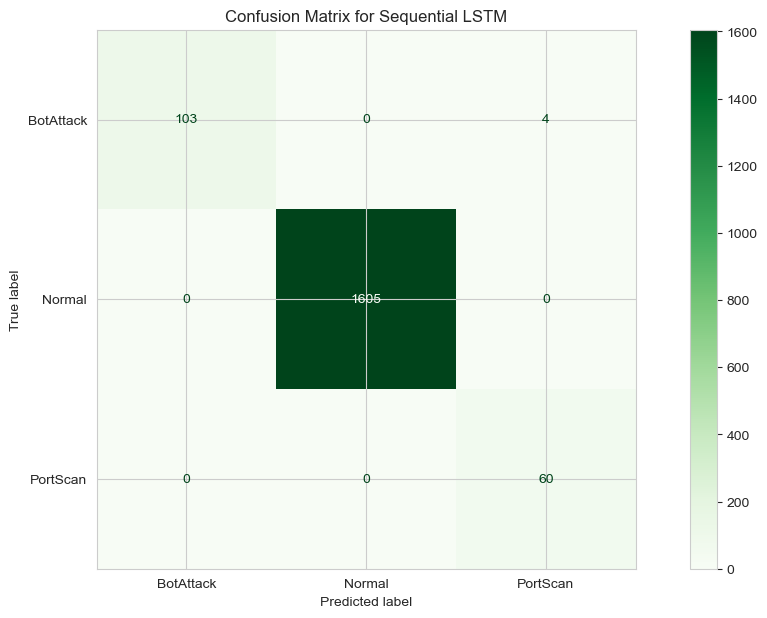

In [18]:
y_pred_prob_lstm = model_lstm.predict(X_test_seq)
y_pred_lstm = np.argmax(y_pred_prob_lstm, axis=1)

print("\nClassification Report (LSTM):")
print(classification_report(y_test_seq, y_pred_lstm, target_names=label_encoder.classes_))

cm_lstm = confusion_matrix(y_test_seq, y_pred_lstm)
disp_lstm = ConfusionMatrixDisplay(confusion_matrix=cm_lstm, display_labels=label_encoder.classes_)
disp_lstm.plot(cmap=plt.cm.Greens)
plt.title("Confusion Matrix for Sequential LSTM")
plt.show()

In [19]:
# Save the models for the dashboard
model_lstm.save('lstm_model_multiclass.keras')
joblib.dump(preprocessor, 'preprocessor_multiclass.joblib')
joblib.dump(label_encoder, 'label_encoder_multiclass.joblib')
print("\nMulti-class models and encoder saved.")


Multi-class models and encoder saved.
